In [ ]:
!pip install bing_image_downloader
!pip install pyblp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00


In [ ]:
car_manufacturers = {
    'AC': 'Acura',
    'AD': 'Audi',
    'AM': 'American Motors General',
    'AR': 'Alfa Romeo',
    'BK': 'Buick',
    'BW': 'BMW',
    'CD': 'Cadillac',
    'CH': 'Chevrolet',
    'CP': 'Chrysler Plymouth',
    'CR': 'Chrysler',
    'CV': 'Chevrolet',
    'DG': 'Dodge',
    'DT': 'Daimler Truck',
    'EA': 'Eagle',
    'EG': 'Eagle',
    'FD': 'Ford',
    'FT': 'Fiat',
    'GE': 'Geo Metro',
    'GO': 'Geo Metro',
    'HD': 'Honda',
    'HN': 'Honda',
    'HY': 'Hyundai',
    'IM': 'International Motors',
    'IN': 'Infiniti',
    'IS': 'Isuzu',
    'JA': 'Jaguar',
    'JG': 'Jaguar',
    'LC': 'Lincoln',
    'LN': 'Lincoln',
    'LX': 'Lexus',
    'MB': 'Mercedes-Benz',
    'MC': 'Mercury',
    'MT': 'Mitsubishi',
    'MZ': 'Mazda',
    'NI': 'Nissan',
    'OD': 'Odsmobile',
    'OP': 'Opel',
    'PG': 'Peugeot',
    'PL': 'Plymouth',
    'PS': 'Porsche',
    'PT': 'Pontiac',
    'RN': 'Renault',
    'SA': 'Saab',
    'SB': 'Subaru',
    'TY': 'Toyota',
    'VV': 'Volvo',
    'VW': 'Volkswagen',
    'YG': 'Yugo',
    'YU': 'Yugo'
}

### Load BLP Data and Images

In [ ]:
import os
import shutil
from tqdm import tqdm
from bing_image_downloader import downloader
from PIL import Image
import torch
from torchvision import models, transforms
import pyblp
import pandas as pd

# Load data
df = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
df['manufacturer'] = df['clustering_ids'].astype(str).str[:2].map(car_manufacturers)
df['model'] = df['clustering_ids'].astype(str).str[2:-2]
df['year'] = '19' + df['clustering_ids'].astype(str).str[-2:]
df['query'] = 'car ' + df['model'] + ' ' + df['year'] + ' ' + df['manufacturer'] + ' ' + df['region']

# Image processing setup
images_dir = '/content/images'
if os.path.exists(images_dir):
    shutil.rmtree(images_dir)
os.makedirs(images_dir, exist_ok=True)

model = models.resnet50(pretrained=True)
model.eval()

def is_car_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    with torch.no_grad():
        out = model(batch_t)
    _, index = torch.max(out, 1)
    return index.item() in [436, 511, 609, 627, 656, 661, 751, 817, 864]

def download_and_process_image(query):
    save_path = os.path.join(images_dir, f"{query.replace(' ', '_')}.jpg")
    if os.path.exists(save_path):
        return
    downloader.download(query, limit=1, output_dir=images_dir, adult_filter_off=True, force_replace=False, timeout=60, verbose=False)
    image_folder = os.path.join(images_dir, query.replace(" ", "_"))
    if os.path.exists(image_folder) and os.listdir(image_folder):
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        if is_car_image(image_path):
            shutil.move(image_path, save_path)

for query in tqdm(df['query'].unique(), desc="Processing Images"):
    download_and_process_image(query)

def cleanup_folders():
    for folder in os.listdir(images_dir):
        folder_path = os.path.join(images_dir, folder)
        if os.path.isdir(folder_path):
            shutil.rmtree(folder_path)

cleanup_folders()


### Load Images into Tensors

In [ ]:
from PIL import Image
import torch
from torchvision import transforms
import os

# Image processing and conversion to tensor
def image_to_tensor(image_path):
    with Image.open(image_path) as img:
        transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to grayscale
            transforms.Resize((120, 120)),  # Resize image
            transforms.ToTensor()  # Convert to tensor
        ])
        return transform(img)

# Directory where images are saved
images_dir = '/content/images'

# Create an empty list to store image tensors
images_tensor = []

# Loop over each row in new_product_data to find corresponding images
for index, row in df.iterrows():
    # Construct folder name
    folder_name = f"car {row['manufacturer']} {row['model']} {row['year']}"
    folder_path = os.path.join(images_dir, folder_name)

    # Check if the folder exists
    if os.path.exists(folder_path):
        try:
            # Assuming the first file is the desired image
            image_file = os.listdir(folder_path)[0]
            image_path = os.path.join(folder_path, image_file)
            # Convert image to tensor and add to list
            image_tensor = image_to_tensor(image_path)
            images_tensor.append(image_tensor)
        except (FileNotFoundError, IndexError):
            print(f"No image found for {folder_path}")
            images_tensor.append(None)  # Append None if no image found
    else:
        print(f"No folder found for {folder_path}")
        images_tensor.append(None)  # Append None if folder not found

images_tensor = [torch.zeros(1, 120, 120) if t is None else t for t in images_tensor]
images_tensor = torch.stack(images_tensor)
torch.save(images_tensor, 'images_tensor.pt')

### Load image tensors

In [ ]:
import pyblp
import numpy as np
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images_tensor = torch.load('images.pt')

### Prepare the data

In [ ]:
df = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
carids = list(df.clustering_ids.unique())
df['shares'] = np.log(df.shares)
outcomes = 'shares'
treatment = 'prices'
covariates = ['hpwt', 'air', 'mpd', 'mpg', 'space', 'trend']
image = ['image']
instruments = ['demand_instruments0', 'demand_instruments1', 'demand_instruments2','demand_instruments3', 'demand_instruments4', 'demand_instruments5','demand_instruments6', 'demand_instruments7']
y = torch.tensor(df[outcomes].values, dtype=torch.float32).reshape(-1).to(device)
t = torch.tensor(df[treatment].values, dtype=torch.float32).reshape(-1).to(device)
x1 = torch.tensor(df[covariates].values, dtype=torch.float32).to(device)
x = images_tensor.clone().to(device)
z = torch.tensor(df[instruments].values, dtype=torch.float32).to(device)
y.shape, t.shape, x.shape, z.shape, x1.shape

(torch.Size([2217]),
 torch.Size([2217]),
 torch.Size([2217, 1, 120, 120]),
 torch.Size([2217, 8]),
 torch.Size([2217, 6]))

### Networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, img_size=120, num_filters=1, d_output=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=3, stride=1)
        # Adjust the size calculation for the linear layer
        conv_output_size = img_size - 2  # Since kernel_size=3 and stride=1
        self.fc1 = nn.Linear(num_filters * conv_output_size * conv_output_size, d_output)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, img_size=120, num_filters=1, d_output=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=3, stride=1)
        # Adjust the size calculation for the linear layer
        conv_output_size = img_size - 2  # Since kernel_size=3 and stride=1
        self.fc1 = nn.Linear(num_filters * conv_output_size * conv_output_size, d_output)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

class CNNX(nn.Module):
    def __init__(self, img_size=120, num_filters=1, d_output=2, d_x=10):
        super(CNNX, self).__init__()

        # Convolutional layers for the image
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=3, stride=1)
        conv_output_size = img_size - 2  # Adjusted for kernel_size=3, stride=1
        self.img_feature_size = num_filters * conv_output_size * conv_output_size

        # Fully connected layers for the non-image covariates
        self.fc_covariates = nn.Linear(d_x, 50) # Example dimension for hidden layer

        # Combine image and non-image pathways
        self.fc_combined = nn.Linear(self.img_feature_size + 50, d_output)

    def forward(self, x_img, x_covariates):
        # Process image
        x_img = F.relu(self.conv1(x_img))
        x_img = torch.flatten(x_img, 1)

        # Process non-image covariates
        x_covariates = F.relu(self.fc_covariates(x_covariates))

        # Combine the two pathways
        combined_input = torch.cat((x_img, x_covariates), dim=1)
        output = self.fc_combined(combined_input)

        return output


In [ ]:
class CNNXZ(nn.Module):
    def __init__(self, img_size=120, num_filters=1, d_output=1, d_x=10, d_z=10):
        super(CNNXZ, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=3, stride=1)
        conv_output_size = img_size - 2  # Adjusted for kernel_size=3, stride=1
        self.img_feature_size = num_filters * conv_output_size * conv_output_size
        self.fc_covariates_x = nn.Linear(d_x, 50)
        self.fc_covariates_z = nn.Linear(d_z, 50)
        self.fc_combined = nn.Linear(self.img_feature_size + 50 + 50, d_output)  # Adjusted for additional z input

    def forward(self, x_img, x_covariates, z_covariates):
        x_img = F.relu(self.conv1(x_img))
        x_img = torch.flatten(x_img, 1)
        x_covariates = F.relu(self.fc_covariates_x(x_covariates))
        z_covariates = F.relu(self.fc_covariates_z(z_covariates))
        combined_input = torch.cat((x_img, x_covariates, z_covariates), dim=1)
        output = self.fc_combined(combined_input)
        return output


### Initialize

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train, x_test, y_train, y_test, t_train, t_test, z_train, z_test, x1_train, x1_test = train_test_split(x, y, t, z, x1, test_size=0.2)
d_x = x_train.shape[1]
n = x_train.shape[0]
arch = [50, 50]
model_ab = CNNX(d_x = x1.shape[1]).to(device)
model_cd = CNNXZ(d_x = x1.shape[1], d_z = z.shape[1]).to(device)
optimizer = torch.optim.Adam(chain(model_ab.parameters(), model_cd.parameters()), lr=0.0001, weight_decay=0.0000)
loss_fn = nn.MSELoss(reduction='mean')

### Train

Loss: 73.91240692138672, (Test) R2 T: 0.06002254989012801, (Test) R2 Y: -1.6897837566423455, Mean Beta: -0.42748570442199707, Mean Alpha: -1.7295961380004883
Loss: 50.25174331665039, (Test) R2 T: 0.29697657319015747, (Test) R2 Y: 0.38253824665458924, Mean Beta: -0.2988445460796356, Mean Alpha: -4.2581024169921875
Loss: 26.24843978881836, (Test) R2 T: 0.6075301036259266, (Test) R2 Y: 0.3960565321745424, Mean Beta: -0.33920127153396606, Mean Alpha: -4.092823505401611
Loss: 13.17920207977295, (Test) R2 T: 0.7636798959286818, (Test) R2 Y: 0.3533611864744639, Mean Beta: -0.28398051857948303, Mean Alpha: -4.82472038269043
Loss: 7.31022834777832, (Test) R2 T: 0.8194979499627831, (Test) R2 Y: 0.34107348579285, Mean Beta: -0.24374055862426758, Mean Alpha: -5.215183734893799
Loss: 4.924112796783447, (Test) R2 T: 0.8414465284113861, (Test) R2 Y: 0.3423885063540121, Mean Beta: -0.23160116374492645, Mean Alpha: -5.349756240844727
Loss: 4.161566734313965, (Test) R2 T: 0.8473977965357122, (Test) R2 Y

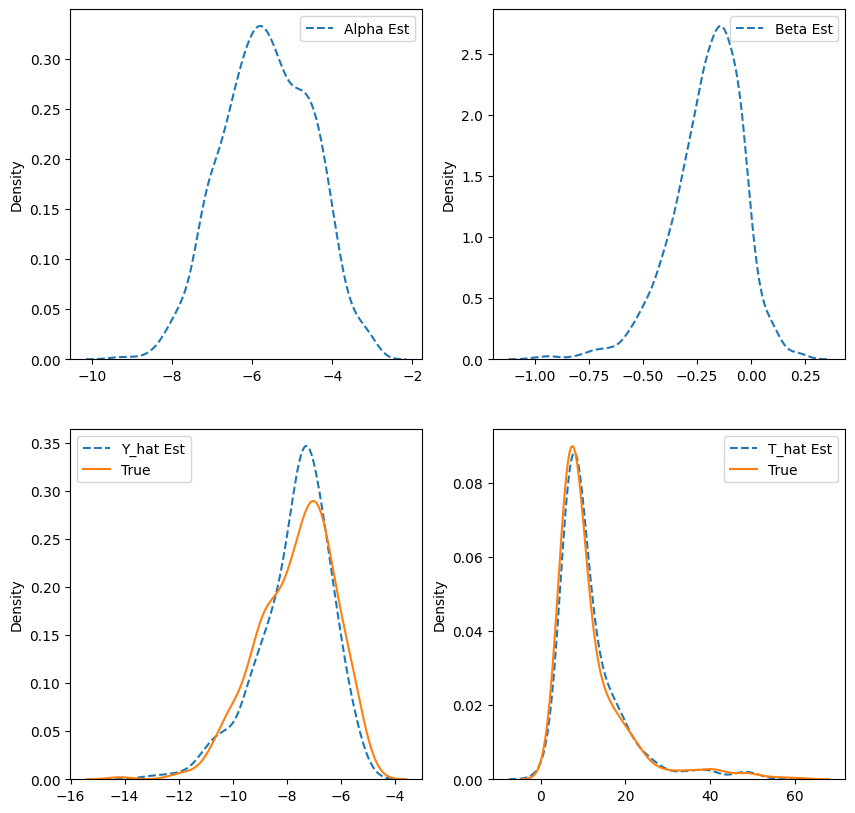

In [ ]:
trua = None
trub = None
m = 10000
for i in range(m):
    ab = model_ab(x_train, x1_train)
    #cd = model_cd(x_train, x1_train)
    alpha = ab[:,0].reshape(n,)
    beta = ab[:,1].reshape(n,)
    #kappa = cd[:,0].reshape(n,)
    #delta = cd[:,1].reshape(n,)
    #t_hat = (kappa + delta * z_train).to(device)
    t_hat = model_cd(x_train, x1_train, z_train).reshape(-1).to(device)
    #y_hat = ((alpha + beta * kappa) + (beta * delta) * z_train).to(device)
    y_hat = (alpha + beta * t_hat).to(device)
    loss = loss_fn(t_hat, t_train) + loss_fn(y_hat, y_train)
    l2_lambda = 0.0002
    l2_reg = torch.tensor(0.).to(device)
    for param in model_ab.parameters():
        l2_reg += torch.norm(param)
    for param in model_cd.parameters():
        l2_reg += torch.norm(param)
    loss += l2_lambda * l2_reg
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % (m/10) == 0:
        with torch.no_grad():
            ab = model_ab(x_test, x1_test)
            #cd = model_cd(x_test, x1_test)
            alpha = ab[:,0].reshape(-1,)
            beta = ab[:,1].reshape(-1,)
            #kappa = cd[:,0].reshape(-1,)
            #delta = cd[:,1].reshape(-1,)
            #t_hat_test = (kappa + delta * z_test).to(device)
            t_hat_test = model_cd(x_test, x1_test, z_test).reshape(-1).to(device)
            #y_hat_test = ((alpha + beta * kappa) + (beta * delta) * z_test).to(device)
            y_hat_test = (alpha + beta * t_hat_test).to(device)
            r2_t = r2_score(t_test.cpu(), t_hat_test.cpu())
            r2_y = r2_score(y_test.cpu(), y_hat_test.cpu())
        print(f"Loss: {loss.item()}, (Test) R2 T: {r2_t}, (Test) R2 Y: {r2_y}, Mean Beta: {torch.mean(beta)}, Mean Alpha: {torch.mean(alpha)}")
# Plot
print('\nPlotting Params and Preds\n')
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.kdeplot(alpha.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha Est', linestyle="--")
if trua is not None:
    sns.kdeplot(a.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha True')
axs[0, 0].legend()
sns.kdeplot(beta.cpu().detach().numpy(), ax=axs[0, 1], label='Beta Est', linestyle="--")
if trub is not None:
    sns.kdeplot(b.cpu().detach().numpy(), ax=axs[0, 1], label='Beta True')
axs[0, 1].legend()
sns.kdeplot(y_hat_test.cpu().detach().numpy(), ax=axs[1, 0], label='Y_hat Est', linestyle="--")
sns.kdeplot(y_test.cpu().detach().numpy(), ax=axs[1, 0], label='True')
axs[1, 0].legend()
sns.kdeplot(t_hat_test.cpu().detach().numpy(), ax=axs[1, 1], label='T_hat Est', linestyle="--")
sns.kdeplot(t_test.cpu().detach().numpy(), ax=axs[1, 1], label='True')
axs[1, 1].legend()
plt.show()

Loss: 2.6981916427612305, (Test) R2 T: 0.8799725003701299, (Test) R2 Y: 0.44165155702990333, Mean Beta: -0.1416899412870407, Mean Alpha: -6.195196151733398
Loss: 2.6787142753601074, (Test) R2 T: 0.8800848045520497, (Test) R2 Y: 0.447430139146592, Mean Beta: -0.13888415694236755, Mean Alpha: -6.196715354919434
Loss: 2.6543426513671875, (Test) R2 T: 0.8800894325502748, (Test) R2 Y: 0.44761275063410244, Mean Beta: -0.13989512622356415, Mean Alpha: -6.204423427581787
Loss: 2.634589433670044, (Test) R2 T: 0.8802779973187337, (Test) R2 Y: 0.451994899561295, Mean Beta: -0.14124862849712372, Mean Alpha: -6.192851543426514
Loss: 2.6178550720214844, (Test) R2 T: 0.8803925545907697, (Test) R2 Y: 0.45642452511283815, Mean Beta: -0.139974445104599, Mean Alpha: -6.203382968902588
Loss: 2.5959274768829346, (Test) R2 T: 0.8807712293338341, (Test) R2 Y: 0.4577456282487091, Mean Beta: -0.13984721899032593, Mean Alpha: -6.208321571350098
Loss: 2.578766345977783, (Test) R2 T: 0.8809092028620648, (Test) R2

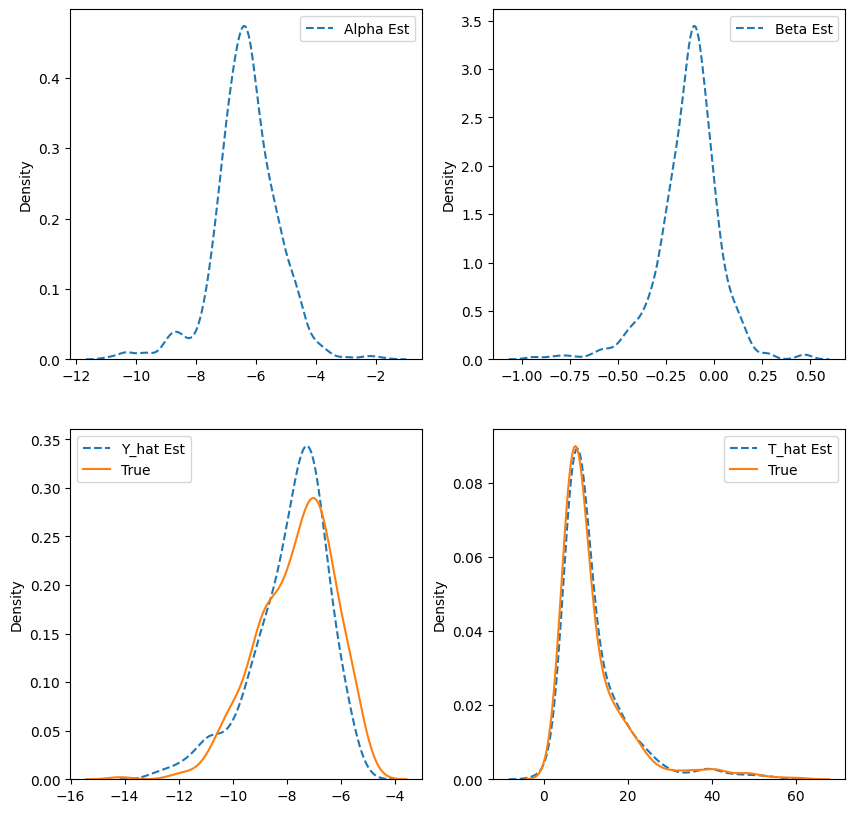

In [ ]:
trua = None
trub = None
m = 5000
for i in range(m):
    ab = model_ab(x_train, x1_train)
    #cd = model_cd(x_train, x1_train)
    alpha = ab[:,0].reshape(n,)
    beta = ab[:,1].reshape(n,)
    #kappa = cd[:,0].reshape(n,)
    #delta = cd[:,1].reshape(n,)
    #t_hat = (kappa + delta * z_train).to(device)
    t_hat = model_cd(x_train, x1_train, z_train).reshape(-1).to(device)
    #y_hat = ((alpha + beta * kappa) + (beta * delta) * z_train).to(device)
    y_hat = (alpha + beta * t_hat).to(device)
    loss = loss_fn(t_hat, t_train) + loss_fn(y_hat, y_train)
    l2_lambda = 0.0002
    l2_reg = torch.tensor(0.).to(device)
    for param in model_ab.parameters():
        l2_reg += torch.norm(param)
    for param in model_cd.parameters():
        l2_reg += torch.norm(param)
    loss += l2_lambda * l2_reg
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % (m/10) == 0:
        with torch.no_grad():
            ab = model_ab(x_test, x1_test)
            #cd = model_cd(x_test, x1_test)
            alpha = ab[:,0].reshape(-1,)
            beta = ab[:,1].reshape(-1,)
            #kappa = cd[:,0].reshape(-1,)
            #delta = cd[:,1].reshape(-1,)
            #t_hat_test = (kappa + delta * z_test).to(device)
            t_hat_test = model_cd(x_test, x1_test, z_test).reshape(-1).to(device)
            #y_hat_test = ((alpha + beta * kappa) + (beta * delta) * z_test).to(device)
            y_hat_test = (alpha + beta * t_hat_test).to(device)
            r2_t = r2_score(t_test.cpu(), t_hat_test.cpu())
            r2_y = r2_score(y_test.cpu(), y_hat_test.cpu())
        print(f"Loss: {loss.item()}, (Test) R2 T: {r2_t}, (Test) R2 Y: {r2_y}, Mean Beta: {torch.mean(beta)}, Mean Alpha: {torch.mean(alpha)}")

print('\nPlotting Params and Preds\n')
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.kdeplot(alpha.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha Est', linestyle="--")
if trua is not None:
    sns.kdeplot(a.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha True')
axs[0, 0].legend()
sns.kdeplot(beta.cpu().detach().numpy(), ax=axs[0, 1], label='Beta Est', linestyle="--")
if trub is not None:
    sns.kdeplot(b.cpu().detach().numpy(), ax=axs[0, 1], label='Beta True')
axs[0, 1].legend()
sns.kdeplot(y_hat_test.cpu().detach().numpy(), ax=axs[1, 0], label='Y_hat Est', linestyle="--")
sns.kdeplot(y_test.cpu().detach().numpy(), ax=axs[1, 0], label='True')
axs[1, 0].legend()
sns.kdeplot(t_hat_test.cpu().detach().numpy(), ax=axs[1, 1], label='T_hat Est', linestyle="--")
sns.kdeplot(t_test.cpu().detach().numpy(), ax=axs[1, 1], label='True')
axs[1, 1].legend()
plt.show()

In [ ]:
df = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
carids = list(df.clustering_ids.unique())
df['shares'] = np.log(df.shares)
outcomes = 'shares'
treatment = 'prices'
covariates = ['hpwt', 'air', 'mpd', 'mpg', 'space', 'trend']
image = ['image']
instruments = ['demand_instruments0', 'demand_instruments1', 'demand_instruments2','demand_instruments3', 'demand_instruments4', 'demand_instruments5','demand_instruments6', 'demand_instruments7']

import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
endog = df[outcomes]
exog =  df[[treatment] + covariates]
instr = df[covariates + instruments]
exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
IV2SLS = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()
print(IV2SLS.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                 shares   R-squared:                       0.334
Model:                         IV2SLS   Adj. R-squared:                  0.331
Method:                     Two Stage   F-statistic:                     146.2
                        Least Squares   Prob (F-statistic):          1.71e-177
Date:                Thu, 25 Jan 2024                                         
Time:                        14:55:53                                         
No. Observations:                2217                                         
Df Residuals:                    2209                                         
Df Model:                           7                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1480      0.378    -29.527      0.0

###

In [ ]:
ab = model_ab(x, x1)
alpha = ab[:,0].reshape(-1,)
beta = ab[:,1].reshape(-1,)

row_indices = torch.where(alpha == torch.min(beta))
idx = row_indices[0][0].item()

df.iloc[idx].clustering_ids

In [ ]:
row_indices = torch.where(alpha == torch.min(beta))
idx = row_indices[0][0].item()

In [ ]:
idx

87

In [ ]:
df.iloc[idx].clustering_ids

'VWBEET71'

In [ ]:
import torch
import pandas as pd

# Assuming df, alpha, and beta are defined as per your context

# Get the indices that would sort alpha and beta
sorted_indices_alpha = torch.argsort(alpha, descending=True)  # For top 5%
sorted_indices_beta = torch.argsort(beta)  # For bottom 5%

# Calculate the number of elements corresponding to 5%
num_elements = int(0.05 * len(alpha))

# Get top 5% indices for alpha
top_alpha_indices = sorted_indices_alpha[:num_elements]
top_alpha_indices = sorted_indices_alpha[:num_elements]

# Get bottom 5% indices for beta
bottom_beta_indices = sorted_indices_beta[:num_elements]

# Select clustering_ids for top 5% of alpha
top_alpha_clustering_ids = df.iloc[top_alpha_indices.tolist()].clustering_ids

# Select clustering_ids for bottom 5% of beta
bottom_beta_clustering_ids = df.iloc[bottom_beta_indices.tolist()].clustering_ids

# Now top_alpha_clustering_ids and bottom_beta_clustering_ids contain the desired values


In [ ]:
top_alpha_clustering_ids

87      VWBEET71
176     VWBEET71
334     VWBEET74
427     VWBEET74
525     VWBEET74
          ...   
2031    PLLEBA89
4       AMAMBS71
23      CVCORV71
929     BKSKYL80
60      PTCATL71
Name: clustering_ids, Length: 110, dtype: object

In [ ]:
import torch
import pandas as pd

# Assuming df, alpha, and beta are defined as per your context

# Get the indices that would sort alpha and beta
sorted_indices_alpha = torch.argsort(alpha, descending=True)  # For top 5% of alpha
sorted_indices_alpha_bottom = torch.argsort(alpha)  # For bottom 5% of alpha
sorted_indices_beta = torch.argsort(beta)  # For bottom 5% of beta
sorted_indices_beta_top = torch.argsort(beta, descending=True)  # For top 5% of beta

# Calculate the number of elements corresponding to 5%
num_elements = int(0.05 * len(alpha))

# Get top and bottom 5% indices for alpha
top_alpha_indices = sorted_indices_alpha[:num_elements]
bottom_alpha_indices = sorted_indices_alpha_bottom[:num_elements]

# Get top and bottom 5% indices for beta
top_beta_indices = sorted_indices_beta_top[:num_elements]
bottom_beta_indices = sorted_indices_beta[:num_elements]

# Select clustering_ids for top and bottom 5% of alpha
top_alpha_clustering_ids = df.iloc[top_alpha_indices.tolist()].clustering_ids
bottom_alpha_clustering_ids = df.iloc[bottom_alpha_indices.tolist()].clustering_ids

# Select clustering_ids for top and bottom 5% of beta
top_beta_clustering_ids = df.iloc[top_beta_indices.tolist()].clustering_ids
bottom_beta_clustering_ids = df.iloc[bottom_beta_indices.tolist()].clustering_ids

# Now you have the clustering_ids for the top and bottom 5% of both alpha and beta


In [ ]:
top_alpha_clustering_ids

87      VWBEET71
176     VWBEET71
334     VWBEET74
427     VWBEET74
525     VWBEET74
          ...   
2031    PLLEBA89
4       AMAMBS71
23      CVCORV71
929     BKSKYL80
60      PTCATL71
Name: clustering_ids, Length: 110, dtype: object

In [ ]:
bottom_alpha_clustering_ids

1713    PT100084
1581    PT100084
1448    PT100084
1325    PT100084
1901    MTCORD84
          ...   
2126    EGSUMM90
1021     PG50580
2184    PLACCL89
2196    SBJUST90
907      PG50580
Name: clustering_ids, Length: 110, dtype: object